#MSDS 686, Deep Learning, Final Project

#Kepler and Tess Exoplanet Classification

#Project Requirements:

##Data:
- Show/plot sample images or data with labels.
- Include at least one of the following:
  - Convolution
  - Max Pooling
  - Batch Normalization
  - Dropout
  - LSTM
  - TF-IDF
- Use validation data
- Evaluate model on test data

##Additional

- Use data augmentation
- Use at least one of the following that was not covered in class:
  - Kernels
  - Activation functions
  - Loss functions
  - Libraries
  - Methods
- Learning rate optimization
- Functional API model
- Transfer learning with or without trainable parameters
- Confusion matrix and/or ROC plots
- Plots of accuracy/loss vs epochs
- Show/plot sample incorrect prediction with labels and correct label

Data Source: https://www.kaggle.com/datasets/vijayveersingh/kepler-and-tess-exoplanet-data

***

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

***

## Importing Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

from google.colab import files
import zipfile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings("ignore")

***

## Loading Data, Creating Directory, Unzipping,

Uploading Kaggle JSON

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"reedjohnson001","key":"1af40eeedcf93fe6a1baf481ccbfdebc"}'}

Creating Directory

In [4]:
! mkdir ~/.kaggle

Copying JSON to directory

In [5]:
! cp kaggle.json ~/.kaggle/

Allowing read/write permissions

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

Downloading the data from Kaggle

In [7]:
!kaggle datasets download -d vijayveersingh/kepler-and-tess-exoplanet-data

Dataset URL: https://www.kaggle.com/datasets/vijayveersingh/kepler-and-tess-exoplanet-data
License(s): Attribution 4.0 International (CC BY 4.0)
100% 44.0M/44.2M [00:03<00:00, 22.4MB/s]
100% 44.2M/44.2M [00:03<00:00, 14.6MB/s]


Unzipping data

In [8]:
!unzip kepler-and-tess-exoplanet-data.zip -d kepler_data

Archive:  kepler-and-tess-exoplanet-data.zip
  inflating: kepler_data/PS_2025.02.03_05.09.36.csv  
  inflating: kepler_data/STELLARHOSTS_2025.02.03_06.11.17.csv  
  inflating: kepler_data/TOI_2025.02.03_06.18.31.csv  
  inflating: kepler_data/keplerstellar_2025.02.03_04.41.47.csv  
  inflating: kepler_data/q1_q17_dr25_koifpp_2025.02.03_06.14.34.csv  
  inflating: kepler_data/q1_q17_dr25_tce_2025.02.03_04.32.18.csv  
  inflating: kepler_data/q1_q8_koi_2025.02.03_04.12.15.csv  


Loop through csv files and loads into dataframe.

In [9]:
directory = "kepler_data"

csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

for file in csv_files:
    file_path = os.path.join(directory, file)
    try:
        df = pd.read_csv(file_path, delimiter=None, engine="python", comment='#')
        print(f"{file}: {df.shape[0]} rows")
    except Exception as e:
        print(f"Error reading {file}: {e}")

keplerstellar_2025.02.03_04.41.47.csv: 990244 rows
STELLARHOSTS_2025.02.03_06.11.17.csv: 46035 rows
TOI_2025.02.03_06.18.31.csv: 7372 rows
q1_q8_koi_2025.02.03_04.12.15.csv: 3865 rows
q1_q17_dr25_tce_2025.02.03_04.32.18.csv: 34032 rows
q1_q17_dr25_koifpp_2025.02.03_06.14.34.csv: 8054 rows
PS_2025.02.03_05.09.36.csv: 38090 rows


Previewing head to see the commented out metadata.  After previewing all of the files I decided that q1_q8_koi_2025 contained all the data that I needed to classify exoplanets.  

In [10]:
!head -n 60 kepler_data/q1_q8_koi_2025.02.03_04.12.15.csv

# This file was produced by the NASA Exoplanet Archive  http://exoplanetarchive.ipac.caltech.edu
# Mon Feb  3 04:12:15 2025
#
# COLUMN kepid:          KepID
# COLUMN kepoi_name:     KOI Name
# COLUMN kepler_name:    Kepler Name
# COLUMN koi_disposition: Exoplanet Archive Disposition
# COLUMN koi_pdisposition: Disposition Using Kepler Data
# COLUMN koi_score:      Disposition Score
# COLUMN koi_fpflag_nt:  Not Transit-Like False Positive Flag
# COLUMN koi_fpflag_ss:  Stellar Eclipse False Positive Flag
# COLUMN koi_fpflag_co:  Centroid Offset False Positive Flag
# COLUMN koi_fpflag_ec:  Ephemeris Match Indicates Contamination False Positive Flag
# COLUMN koi_period:     Orbital Period [days]
# COLUMN koi_period_err1: Orbital Period Upper Unc. [days]
# COLUMN koi_period_err2: Orbital Period Lower Unc. [days]
# COLUMN koi_time0bk:    Transit Epoch [BKJD]
# COLUMN koi_time0bk_err1: Transit Epoch Upper Unc. [BKJD]
# COLUMN koi_time0bk_err2: Transit Epoch Lower Unc. [BKJD]
# COLUMN koi_impac

***

## Loading into DF and Previewing Data

Created a DF with only the q1_q8_koi_2025 data.  

In [11]:
q1_q8_koi_df = pd.read_csv("kepler_data/q1_q8_koi_2025.02.03_04.12.15.csv", comment = '#')

In [12]:
q1_q8_koi_df.head(10)

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,9388479,K00936.02,Kepler-732 c,CONFIRMED,CANDIDATE,NaN,NaN,NaN,NaN,NaN,...,-200.0,4.76,0.3,-0.3,0.496,0.023,-0.023,283.73203,45.958771,15.073
1,8359498,K00127.01,Kepler-77 b,CONFIRMED,CANDIDATE,NaN,NaN,NaN,NaN,NaN,...,-50.0,4.45,0.1,-0.1,1.039,0.045,-0.045,289.60797,44.345421,13.938
2,9406990,K00937.01,Kepler-733 b,CONFIRMED,CANDIDATE,NaN,NaN,NaN,NaN,NaN,...,-102.0,4.60,0.3,-0.3,0.780,0.240,-0.240,293.01828,45.914688,15.412
3,9415172,K00938.01,Kepler-255 c,CONFIRMED,CANDIDATE,NaN,NaN,NaN,NaN,NaN,...,-128.0,4.58,0.3,-0.3,0.800,0.380,-0.380,296.06424,45.976841,15.596
4,9415172,K00938.02,Kepler-255 d,CONFIRMED,CANDIDATE,NaN,NaN,NaN,NaN,NaN,...,-128.0,4.58,0.3,-0.3,0.800,0.380,-0.380,296.06424,45.976841,15.596
5,9415172,K00938.03,Kepler-255 b,CONFIRMED,NOT DISPOSITIONED,NaN,NaN,NaN,NaN,NaN,...,-128.0,4.58,0.3,-0.3,0.800,0.380,-0.380,296.06424,45.976841,15.596
6,9466668,K00939.01,Kepler-256 c,CONFIRMED,CANDIDATE,NaN,NaN,NaN,NaN,NaN,...,-159.0,4.54,0.3,-0.3,0.890,0.440,-0.440,292.58044,46.097389,15.065
7,9466668,K00939.02,Kepler-256 d,CONFIRMED,NOT DISPOSITIONED,NaN,NaN,NaN,NaN,NaN,...,-159.0,4.54,0.3,-0.3,0.890,0.440,-0.440,292.58044,46.097389,15.065
8,9466668,K00939.03,Kepler-256 b,CONFIRMED,NOT DISPOSITIONED,NaN,NaN,NaN,NaN,NaN,...,-159.0,4.54,0.3,-0.3,0.890,0.440,-0.440,292.58044,46.097389,15.065
9,9466668,K00939.04,Kepler-256 e,CONFIRMED,NOT DISPOSITIONED,NaN,NaN,NaN,NaN,NaN,...,-159.0,4.54,0.3,-0.3,0.890,0.440,-0.440,292.58044,46.097389,15.065


In [13]:
q1_q8_koi_df.tail(10)

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
3855,6685609,K00665.02,Kepler-207 b,CONFIRMED,CANDIDATE,NaN,NaN,NaN,NaN,NaN,...,-87.0,4.370,0.3,-0.3,1.100,0.430,-0.430,290.03052,42.166050,13.182
3856,6685609,K00665.03,Kepler-207 c,CONFIRMED,CANDIDATE,NaN,NaN,NaN,NaN,NaN,...,-87.0,4.370,0.3,-0.3,1.100,0.430,-0.430,290.03052,42.166050,13.182
3857,6707835,K00666.01,Kepler-640 b,CONFIRMED,CANDIDATE,NaN,NaN,NaN,NaN,NaN,...,-50.0,4.450,0.1,-0.1,1.020,0.062,-0.062,296.03220,42.131672,13.721
3858,6752502,K00667.01,NaN,FALSE POSITIVE,FALSE POSITIVE,NaN,NaN,NaN,NaN,NaN,...,NaN,4.566,NaN,NaN,0.668,NaN,NaN,282.15491,42.234547,13.826
3859,6805146,K00668.01,NaN,NOT DISPOSITIONED,NOT DISPOSITIONED,NaN,NaN,NaN,NaN,NaN,...,-112.0,4.220,0.3,-0.3,1.430,0.480,-0.480,298.59164,42.206429,13.210
3860,6960445,K00669.01,NaN,FALSE POSITIVE,FALSE POSITIVE,NaN,NaN,NaN,NaN,NaN,...,-85.0,4.470,0.3,-0.3,0.910,0.400,-0.400,295.19562,42.417068,13.842
3861,7033671,K00670.01,Kepler-641 b,CONFIRMED,CANDIDATE,NaN,NaN,NaN,NaN,NaN,...,-118.0,4.350,0.3,-0.3,1.060,0.500,-0.500,291.82349,42.516209,13.774
3862,7040629,K00671.01,Kepler-208 b,CONFIRMED,CANDIDATE,NaN,NaN,NaN,NaN,NaN,...,NaN,4.446,NaN,NaN,0.972,NaN,NaN,293.89020,42.527966,13.749
3863,7040629,K00671.02,Kepler-208 c,CONFIRMED,CANDIDATE,NaN,NaN,NaN,NaN,NaN,...,NaN,4.446,NaN,NaN,0.972,NaN,NaN,293.89020,42.527966,13.749
3864,11553706,K00009.01,NaN,NOT DISPOSITIONED,NOT DISPOSITIONED,NaN,NaN,NaN,NaN,NaN,...,-72.0,4.450,0.3,-0.3,1.050,0.450,-0.450,288.80377,49.530788,13.123


In [14]:
q1_q8_koi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3865 entries, 0 to 3864
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepid              3865 non-null   int64  
 1   kepoi_name         3865 non-null   object 
 2   kepler_name        2319 non-null   object 
 3   koi_disposition    3865 non-null   object 
 4   koi_pdisposition   3865 non-null   object 
 5   koi_score          0 non-null      float64
 6   koi_fpflag_nt      0 non-null      float64
 7   koi_fpflag_ss      0 non-null      float64
 8   koi_fpflag_co      0 non-null      float64
 9   koi_fpflag_ec      0 non-null      float64
 10  koi_period         3865 non-null   float64
 11  koi_period_err1    3845 non-null   float64
 12  koi_period_err2    3845 non-null   float64
 13  koi_time0bk        3865 non-null   float64
 14  koi_time0bk_err1   3845 non-null   float64
 15  koi_time0bk_err2   3845 non-null   float64
 16  koi_impact         3865 

***

## Some Basic EDA and Data Cleaning

Several empty columns above. Boxplot below doesnt show much because of the various data scales.  Lots of outliers.   

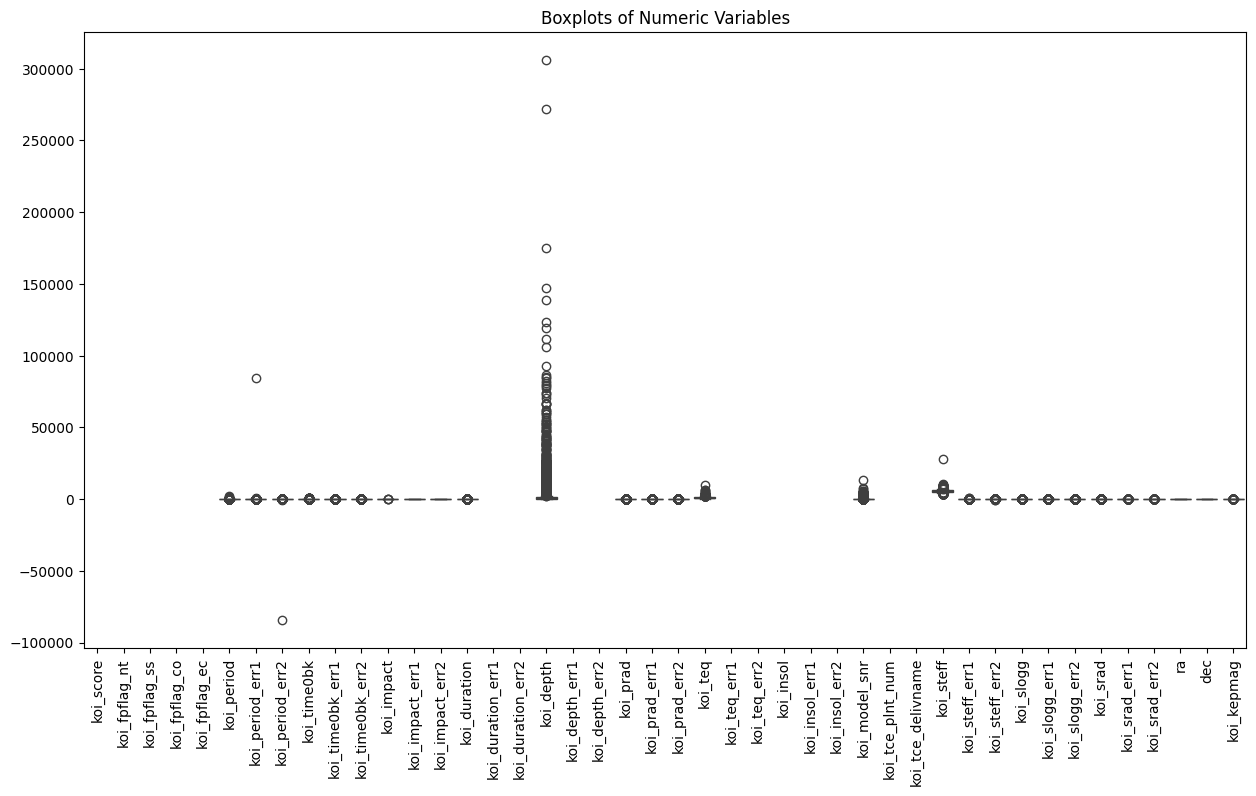

In [15]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=q1_q8_koi_df.drop(columns=['kepid']))
plt.xticks(rotation=90)
plt.title("Boxplots of Numeric Variables")
plt.show()

Below I calculate the percent of my data that is outliers for the numeric columns.  

In [16]:
def calculate_outlier_percentage(data):

    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    outlier_percentage = (len(outliers) / len(data)) * 100
    return outlier_percentage

for col in q1_q8_koi_df.select_dtypes(include=np.number).columns:
    percentage = calculate_outlier_percentage(q1_q8_koi_df[col])
    print(f"Percentage of outliers in {col}: {percentage:.2f}%")

Percentage of outliers in kepid: 0.00%
Percentage of outliers in koi_score: 0.00%
Percentage of outliers in koi_fpflag_nt: 0.00%
Percentage of outliers in koi_fpflag_ss: 0.00%
Percentage of outliers in koi_fpflag_co: 0.00%
Percentage of outliers in koi_fpflag_ec: 0.00%
Percentage of outliers in koi_period: 11.44%
Percentage of outliers in koi_period_err1: 0.00%
Percentage of outliers in koi_period_err2: 0.00%
Percentage of outliers in koi_time0bk: 5.90%
Percentage of outliers in koi_time0bk_err1: 0.00%
Percentage of outliers in koi_time0bk_err2: 0.00%
Percentage of outliers in koi_impact: 0.08%
Percentage of outliers in koi_impact_err1: 0.00%
Percentage of outliers in koi_impact_err2: 0.00%
Percentage of outliers in koi_duration: 5.12%
Percentage of outliers in koi_duration_err1: 0.00%
Percentage of outliers in koi_duration_err2: 0.00%
Percentage of outliers in koi_depth: 15.32%
Percentage of outliers in koi_depth_err1: 0.00%
Percentage of outliers in koi_depth_err2: 0.00%
Percentage o

I dont think that removing 16% of my data is a wise idea so I'm leaving the outliers alone.

Right away it seems like the columns below are pretty useless.  Dropping them.  

In [17]:
q1_q8_koi_df = q1_q8_koi_df.drop(['kepoi_name', 'kepler_name', 'koi_pdisposition'], axis=1)

In [18]:
print(q1_q8_koi_df['koi_disposition'].unique())

['CONFIRMED' 'NOT DISPOSITIONED' 'FALSE POSITIVE' 'CANDIDATE']


Lets look at the balance of the target data.  

Code below from: https://www.kaggle.com/code/vijayveersingh/1-eda-kepler-tess-data

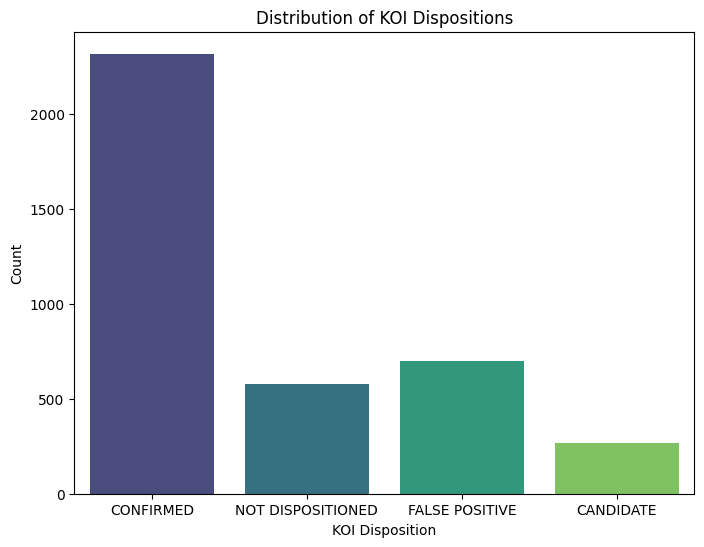

In [19]:
plt.figure(figsize=(8, 6))
sns.countplot(x='koi_disposition', data=q1_q8_koi_df, palette='viridis')
plt.title('Distribution of KOI Dispositions')
plt.xlabel('KOI Disposition')
plt.ylabel('Count')
plt.show()

The data is fairly unbalanced with many more confirmed than false positives or candidates.  The "Not Dispositioned" data wont help the model so I'm dropping.  

In [20]:
q1_q8_koi_df = q1_q8_koi_df[q1_q8_koi_df['koi_disposition'] != 'NOT DISPOSITIONED']

****

## Encoding Labels

In [21]:
le = LabelEncoder()

In [22]:
q1_q8_koi_df['koi_disposition'] = le.fit_transform(q1_q8_koi_df['koi_disposition'])

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

label_mapping

{'CANDIDATE': 0, 'CONFIRMED': 1, 'FALSE POSITIVE': 2}

***

## Handling Missing Data

Heatmap of missing data below.  Relatively minor % data missing outside of the full missing columns.  

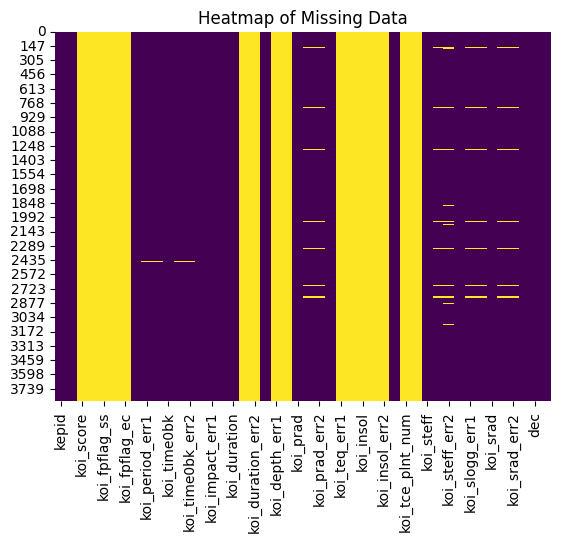

In [23]:
sns.heatmap(q1_q8_koi_df.isnull(), cbar=False, cmap="viridis")
plt.title("Heatmap of Missing Data")
plt.show()

Missing data in percent below.  

In [24]:
print(q1_q8_koi_df.apply(lambda x:x.isnull().sum()/len(q1_q8_koi_df) *100))

kepid                  0.000000
koi_disposition        0.000000
koi_score            100.000000
koi_fpflag_nt        100.000000
koi_fpflag_ss        100.000000
koi_fpflag_co        100.000000
koi_fpflag_ec        100.000000
koi_period             0.000000
koi_period_err1        0.486914
koi_period_err2        0.486914
koi_time0bk            0.000000
koi_time0bk_err1       0.486914
koi_time0bk_err2       0.486914
koi_impact             0.000000
koi_impact_err1        0.000000
koi_impact_err2        0.000000
koi_duration           0.000000
koi_duration_err1    100.000000
koi_duration_err2    100.000000
koi_depth              0.000000
koi_depth_err1       100.000000
koi_depth_err2       100.000000
koi_prad               0.000000
koi_prad_err1          3.377967
koi_prad_err2          3.377967
koi_teq                0.000000
koi_teq_err1         100.000000
koi_teq_err2         100.000000
koi_insol            100.000000
koi_insol_err1       100.000000
koi_insol_err2       100.000000
koi_mode

I'm assuming that any column with >50% data missing is useless.  Here I use 50% as a threshold and use that to remove columns with a high percentage of missing data.  

In [25]:
q1_q8_koi_df = q1_q8_koi_df.dropna(axis=1, thresh=0.5 * len(q1_q8_koi_df))

High % missing data columns removed.  

In [26]:
print(q1_q8_koi_df.apply(lambda x:x.isnull().sum()/len(q1_q8_koi_df) *100))

kepid               0.000000
koi_disposition     0.000000
koi_period          0.000000
koi_period_err1     0.486914
koi_period_err2     0.486914
koi_time0bk         0.000000
koi_time0bk_err1    0.486914
koi_time0bk_err2    0.486914
koi_impact          0.000000
koi_impact_err1     0.000000
koi_impact_err2     0.000000
koi_duration        0.000000
koi_depth           0.000000
koi_prad            0.000000
koi_prad_err1       3.377967
koi_prad_err2       3.377967
koi_teq             0.000000
koi_model_snr       0.000000
koi_steff           0.000000
koi_steff_err1      3.377967
koi_steff_err2      4.321363
koi_slogg           0.000000
koi_slogg_err1      3.377967
koi_slogg_err2      3.377967
koi_srad            0.000000
koi_srad_err1       3.377967
koi_srad_err2       3.377967
ra                  0.000000
dec                 0.000000
koi_kepmag          0.000000
dtype: float64


***

## Pearson Correlation Matrix and Heatmap

In [27]:
q1_q8_koi_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3286 entries, 0 to 3863
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   kepid             3286 non-null   int64  
 1   koi_disposition   3286 non-null   int64  
 2   koi_period        3286 non-null   float64
 3   koi_period_err1   3270 non-null   float64
 4   koi_period_err2   3270 non-null   float64
 5   koi_time0bk       3286 non-null   float64
 6   koi_time0bk_err1  3270 non-null   float64
 7   koi_time0bk_err2  3270 non-null   float64
 8   koi_impact        3286 non-null   float64
 9   koi_impact_err1   3286 non-null   float64
 10  koi_impact_err2   3286 non-null   float64
 11  koi_duration      3286 non-null   float64
 12  koi_depth         3286 non-null   int64  
 13  koi_prad          3286 non-null   float64
 14  koi_prad_err1     3175 non-null   float64
 15  koi_prad_err2     3175 non-null   float64
 16  koi_teq           3286 non-null   float64
 17  

I'd like to get a sense for any internal correlations so I can start thinking about feature selection.   

In [28]:
correlation_matrix = q1_q8_koi_df.corr()
correlation_matrix

,kepid,koi_disposition,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
kepid,1.000000,-0.064144,0.008224,0.000459,-0.000459,-0.026412,-0.027492,0.027492,0.006462,-0.013746,...,0.069835,0.019769,-0.006709,0.006709,0.011750,-0.007466,0.007466,-0.012580,0.993763,-0.015442
koi_disposition,-0.064144,1.000000,-0.142053,-0.004995,0.004995,-0.003652,0.038393,-0.038393,-0.155883,0.028770,...,-0.103011,-0.021265,0.096703,-0.096703,0.010017,0.088869,-0.088869,0.110868,-0.062227,0.012378
koi_period,0.008224,-0.142053,1.000000,0.110968,-0.110968,0.250235,0.124023,-0.124023,0.073597,-0.057305,...,0.044308,-0.061075,-0.076039,0.076039,0.034280,-0.013371,0.013371,0.007321,0.009852,-0.039819
koi_period_err1,0.000459,-0.004995,0.110968,1.000000,-1.000000,0.145326,-0.007772,0.007772,0.006097,-0.017975,...,0.022959,0.009002,-0.047854,0.047854,-0.006425,-0.029036,0.029036,-0.029186,-0.000171,-0.014798
koi_period_err2,-0.000459,0.004995,-0.110968,-1.000000,1.000000,-0.145326,0.007772,-0.007772,-0.006097,0.017975,...,-0.022959,-0.009002,0.047854,-0.047854,0.006425,0.029036,-0.029036,0.029186,0.000171,0.014798
koi_time0bk,-0.026412,-0.003652,0.250235,0.145326,-0.145326,1.000000,-0.013681,0.013681,0.037327,-0.053906,...,-0.254313,0.020712,-0.040214,0.040214,0.001656,-0.065374,0.065374,0.001158,-0.027767,0.084095
koi_time0bk_err1,-0.027492,0.038393,0.124023,-0.007772,0.007772,-0.013681,1.000000,-1.000000,0.019909,0.124794,...,-0.112015,-0.018076,0.081284,-0.081284,0.021594,0.046739,-0.046739,-0.008940,-0.021170,0.061662
koi_time0bk_err2,0.027492,-0.038393,-0.124023,0.007772,-0.007772,0.013681,-1.000000,1.000000,-0.019909,-0.124794,...,0.112015,0.018076,-0.081284,0.081284,-0.021594,-0.046739,0.046739,0.008940,0.021170,-0.061662
koi_impact,0.006462,-0.155883,0.073597,0.006097,-0.006097,0.037327,0.019909,-0.019909,1.000000,-0.101291,...,0.003622,-0.083613,-0.014951,0.014951,0.045269,0.033293,-0.033293,-0.043961,0.005241,-0.028824
koi_impact_err1,-0.013746,0.028770,-0.057305,-0.017975,0.017975,-0.053906,0.124794,-0.124794,-0.101291,1.000000,...,-0.125694,0.160426,0.203044,-0.203044,-0.090547,-0.005796,0.005796,0.016912,-0.011338,0.191372


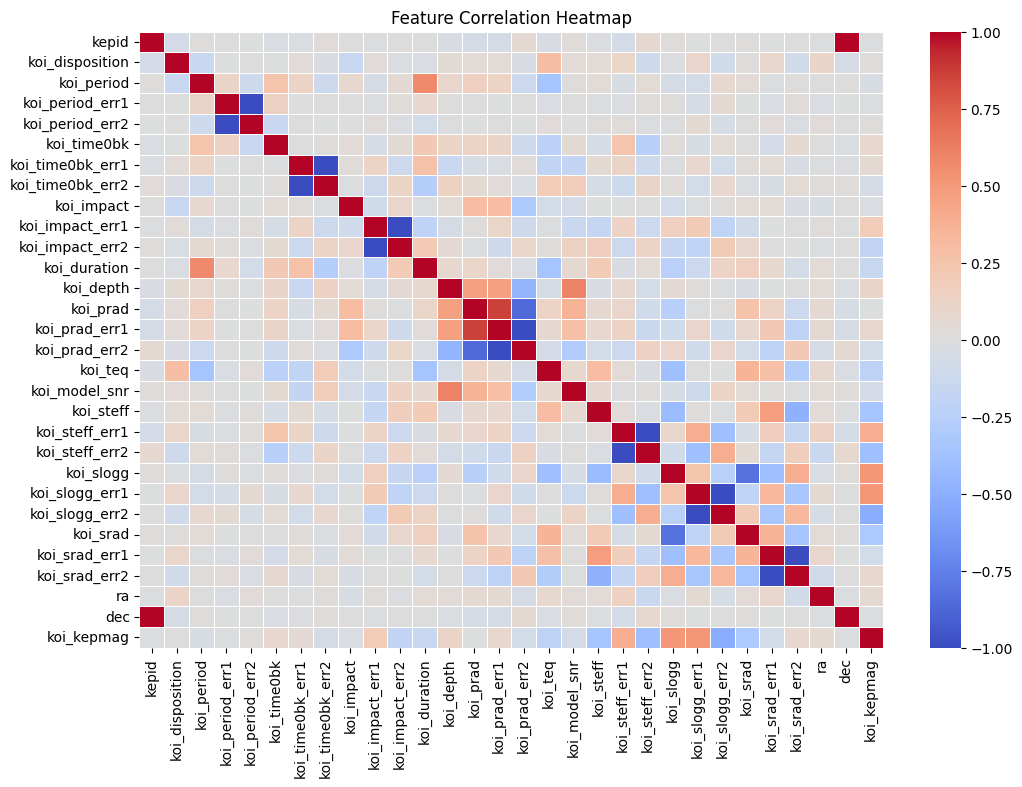

In [29]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

From a visual standpoint nothing is strongly correlated with disposition. Lots of weak correlations.  koi_teq has the strongest correlation.  Below I sort the correlation values in regard to disposition.  Again kio_teq is the best at 0.29.  

In [30]:
target_correlation = q1_q8_koi_df.corr()['koi_disposition'].abs().sort_values(ascending=False)
target_correlation

,koi_disposition
koi_disposition,1.000000
koi_teq,0.294076
koi_impact,0.155883
koi_period,0.142053
ra,0.110868
koi_steff_err2,0.103011
koi_steff_err1,0.102549
koi_slogg_err1,0.096703
koi_slogg_err2,0.096703
koi_srad_err1,0.088869


***

## Feature Selection First Pass

Here I drop features with correlation values < 0.05.  They are likely useless.  

In [31]:
low_corr_features = target_correlation[target_correlation < 0.05].index.tolist()

In [32]:
q1_q8_koi_df = q1_q8_koi_df.drop(columns=low_corr_features)

In [33]:
q1_q8_koi_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3286 entries, 0 to 3863
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   kepid            3286 non-null   int64  
 1   koi_disposition  3286 non-null   int64  
 2   koi_period       3286 non-null   float64
 3   koi_impact       3286 non-null   float64
 4   koi_depth        3286 non-null   int64  
 5   koi_teq          3286 non-null   float64
 6   koi_steff_err1   3175 non-null   float64
 7   koi_steff_err2   3144 non-null   float64
 8   koi_slogg_err1   3175 non-null   float64
 9   koi_slogg_err2   3175 non-null   float64
 10  koi_srad_err1    3175 non-null   float64
 11  koi_srad_err2    3175 non-null   float64
 12  ra               3286 non-null   float64
 13  dec              3286 non-null   float64
dtypes: float64(11), int64(3)
memory usage: 385.1 KB


***

## Checking Magnitudes of Data

In [34]:
q1_q8_koi_df.describe()

,kepid,koi_disposition,koi_period,koi_impact,koi_depth,koi_teq,koi_steff_err1,koi_steff_err2,koi_slogg_err1,koi_slogg_err2,koi_srad_err1,koi_srad_err2,ra,dec
count,3.286000e+03,3286.000000,3286.000000,3286.000000,3286.000000,3286.000000,3175.000000,3144.000000,3175.000000,3175.000000,3175.000000,3175.000000,3286.000000,3286.000000
mean,7.881627e+06,1.131771,24.884707,0.583893,2155.358186,920.425137,102.287874,-102.320293,0.277421,-0.277421,0.342709,-0.342709,291.633654,44.076064
std,2.652960e+06,0.526885,61.545344,0.326863,7593.710780,482.088411,43.942532,44.157487,0.063246,0.063246,0.215646,0.215646,4.828221,3.621872
min,7.574500e+05,0.000000,0.241839,0.000000,5.000000,138.000000,44.000000,-500.000000,0.010000,-0.500000,0.006500,-2.200000,280.258390,36.577381
25%,5.796308e+06,1.000000,3.882778,0.330000,220.000000,586.000000,73.500000,-116.000000,0.300000,-0.300000,0.210000,-0.450000,287.971675,41.073787
50%,8.162310e+06,1.000000,9.180167,0.660000,468.000000,818.000000,92.000000,-92.000000,0.300000,-0.300000,0.350000,-0.350000,291.880650,44.026459
75%,1.002661e+07,1.000000,22.059522,0.840000,996.500000,1141.750000,115.000000,-73.000000,0.300000,-0.300000,0.450000,-0.210000,295.520470,46.981640
max,1.293514e+07,2.000000,2015.635290,1.550000,138944.000000,4859.000000,500.000000,-44.000000,0.500000,-0.010000,2.200000,-0.006500,301.720760,52.336010


***

## Define Features and Targets

Splitting the data into features and targets.  

In [35]:
X = q1_q8_koi_df.drop(columns=['koi_disposition', 'kepid'], errors='ignore')
y = q1_q8_koi_df['koi_disposition']

In [36]:
X.head(10)

,koi_period,koi_impact,koi_depth,koi_teq,koi_steff_err1,koi_steff_err2,koi_slogg_err1,koi_slogg_err2,koi_srad_err1,koi_srad_err2,ra,dec
0,0.893048,0.750,738,973.0,200.0,-200.0,0.3,-0.3,0.023,-0.023,283.73203,45.958771
1,3.578783,0.025,11445,1189.0,50.0,-50.0,0.1,-0.1,0.045,-0.045,289.60797,44.345421
2,20.834950,0.340,994,559.0,102.0,-102.0,0.3,-0.3,0.240,-0.240,293.01828,45.914688
3,9.946049,0.830,1034,729.0,128.0,-128.0,0.3,-0.3,0.380,-0.380,296.06424,45.976841
4,1.045632,0.770,214,1561.0,128.0,-128.0,0.3,-0.3,0.380,-0.380,296.06424,45.976841
5,5.714420,0.892,284,878.0,128.0,-128.0,0.3,-0.3,0.380,-0.380,296.06424,45.976841
6,3.388008,0.540,282,1165.0,159.0,-159.0,0.3,-0.3,0.440,-0.440,292.58044,46.097389
7,5.839061,0.590,276,973.0,159.0,-159.0,0.3,-0.3,0.440,-0.440,292.58044,46.097389
8,1.620436,0.530,146,1487.0,159.0,-159.0,0.3,-0.3,0.440,-0.440,292.58044,46.097389
9,10.681760,0.660,296,793.0,159.0,-159.0,0.3,-0.3,0.440,-0.440,292.58044,46.097389


In [37]:
y.head(10)

,koi_disposition
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1


***

## Scaling

There were some pretty significant differences in the data magnitudes.  Here I scale the X data with standard scaler.  

In [38]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

***

## Train Test Split

I opted to split out the validation data in the models below.  

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

***

## Imputing

Imputing the missing X data with the median. Max missing data for any column above was 4%.  

In [40]:
imputer = SimpleImputer(strategy="median")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

***

## Convert the Targets to Categorical

In [41]:
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

***

## Model 1: Standard FNN

Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.4951 - loss: 1.2939 - val_accuracy: 0.7249 - val_loss: 0.7826
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7123 - loss: 0.8035 - val_accuracy: 0.7508 - val_loss: 0.6643
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7180 - loss: 0.7555 - val_accuracy: 0.7523 - val_loss: 0.6358
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7692 - loss: 0.6753 - val_accuracy: 0.7629 - val_loss: 0.6150
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7516 - loss: 0.6991 - val_accuracy: 0.7720 - val_loss: 0.6035
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7474 - loss: 0.6756 - val_accuracy: 0.7812 - val_loss: 0.6028
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7627 - loss: 0.6637 - val_accuracy: 0.7964 - val_loss: 0.5915
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7855 - loss: 0.6116 - val_accuracy: 0.7964 - 

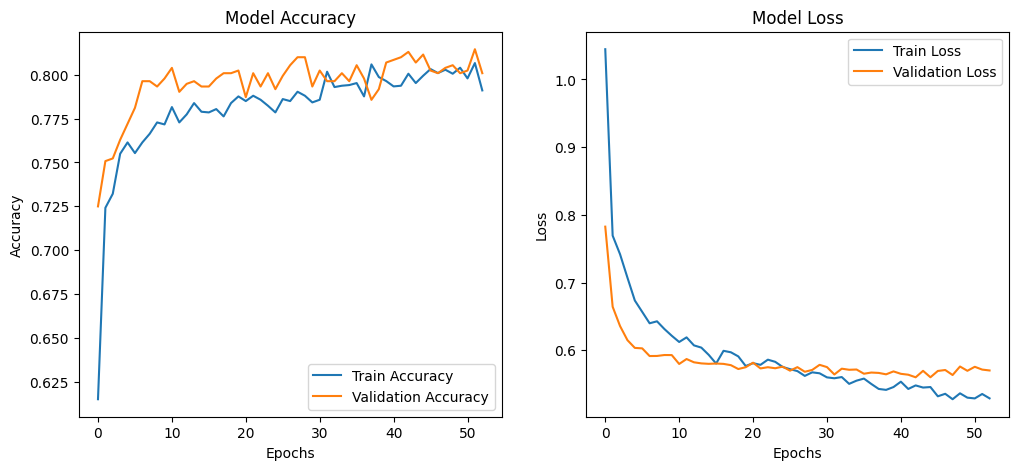

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8259 - loss: 0.5382 
Test Accuracy: 0.8131
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


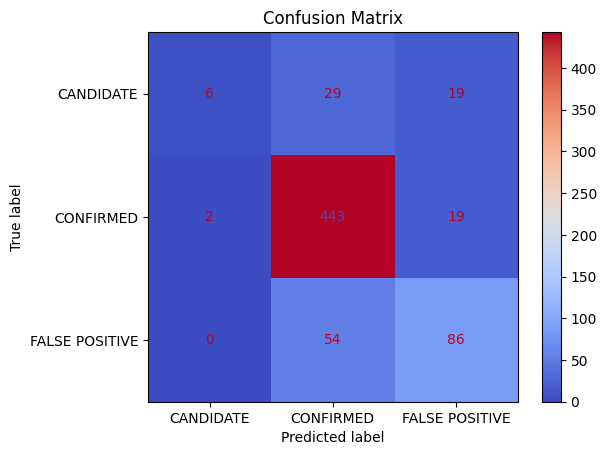

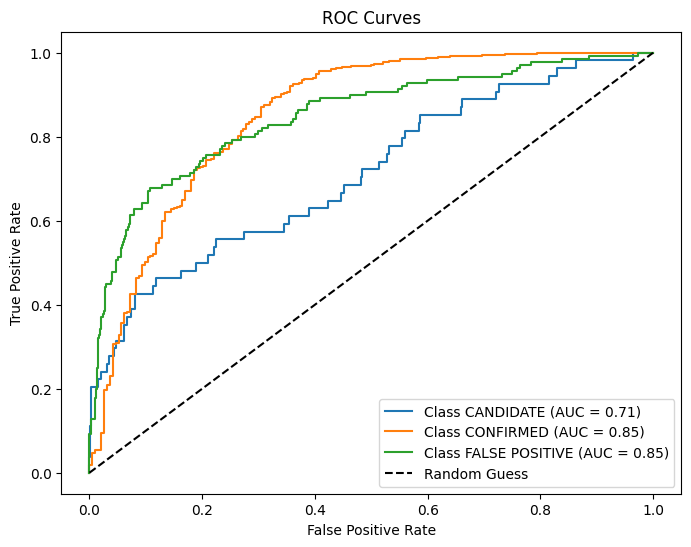

In [42]:
K.clear_session()

model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(3, activation='softmax')
])


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    validation_split = 0.2,
    callbacks=[early_stopping]
)

#Accuracy and Loss Plots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()

plt.show()


loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

#Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
labels = ["CANDIDATE", "CONFIRMED", "FALSE POSITIVE"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="coolwarm", values_format="d")
plt.title("Confusion Matrix")
plt.show()

#ROC Curves
y_test_bin = label_binarize(y_true, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.show()

***

## Feature Selection Second Pass - Random Forest Classifier

I'd like to see if I can improve the model above by narrowing down the features further.  I implemented a random forest classifier to determine feature importance.

In [43]:
print(y_train[:5])

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


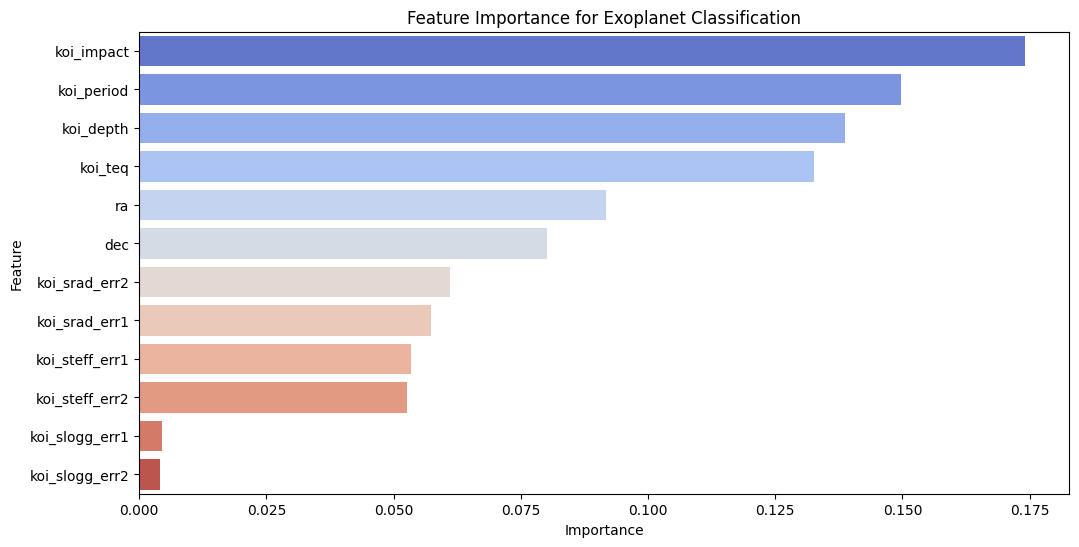

In [44]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, np.argmax(y_train, axis=1))

feature_names = q1_q8_koi_df.drop(columns=['koi_disposition', 'kepid'], errors='ignore').columns

feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance['Importance'], y=feature_importance['Feature'], palette="coolwarm")
plt.title("Feature Importance for Exoplanet Classification")
plt.show()

Looks like the error columns are all low importance.  Below I get rid of them and create a new filtered dataset with the top six features.  

In [45]:
low_importance_features = ["koi_slogg_err1", "koi_slogg_err2", "koi_steff_err1", "koi_steff_err2",
                           "koi_srad_err1", "koi_srad_err2"]

In [46]:
keep_indices = [i for i, feature in enumerate(feature_names) if feature not in low_importance_features]

X_train_filtered = X_train[:, keep_indices]
X_test_filtered = X_test[:, keep_indices]

filtered_feature_names = feature_names[keep_indices]

print(f"New feature count: {X_train_filtered.shape[1]}")
print(f"Selected Features: {filtered_feature_names}")

New feature count: 6
Selected Features: Index(['koi_period', 'koi_impact', 'koi_depth', 'koi_teq', 'ra', 'dec'], dtype='object')


Double checking data shape.

In [47]:
print(f"X_train shape: {X_train_filtered.shape}, X_test shape: {X_test_filtered.shape}")

X_train shape: (2628, 6), X_test shape: (658, 6)


***

## Model 2 FNN, Utilizing Random Forest Classifier for Feature Selection Above

Additional depth, adjusted learning rate, adjusted dropout, altered learning rate.

Epoch 1/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 188ms/step - accuracy: 0.5362 - loss: 1.1365 - val_accuracy: 0.7129 - val_loss: 0.9031
Epoch 2/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7527 - loss: 0.7341 - val_accuracy: 0.7129 - val_loss: 0.8301
Epoch 3/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7595 - loss: 0.7313 - val_accuracy: 0.7091 - val_loss: 0.8051
Epoch 4/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7587 - loss: 0.7149 - val_accuracy: 0.7091 - val_loss: 0.7889
Epoch 5/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7761 - loss: 0.6719 - val_accuracy: 0.7091 - val_loss: 0.7756
Epoch 6/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7628 - loss: 0.6998 - val_accuracy: 0.7110 - val_loss: 0.7795
Epoch 7/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7819 - loss: 0.6606 - val_accuracy: 0.7129 - val_loss: 0.7729
Epoch 8/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7611 - loss: 0.6885 - val_accuracy: 0.7262 

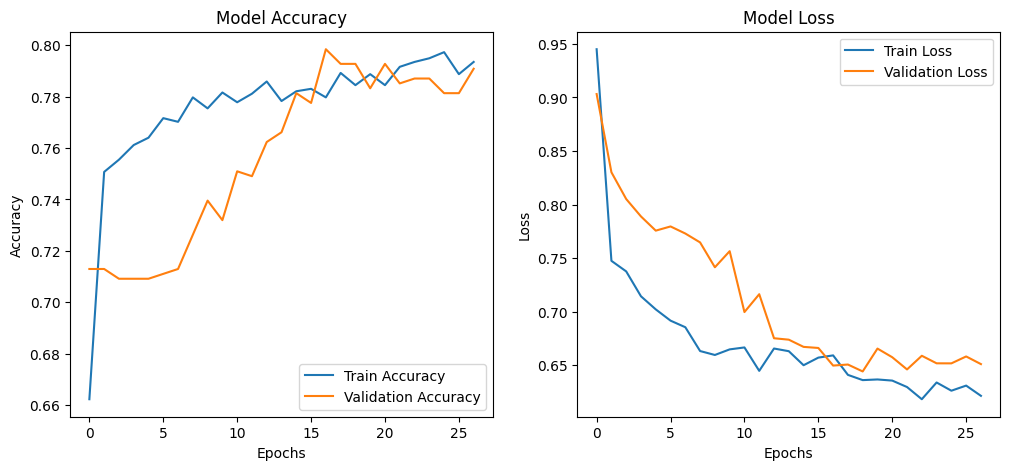

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8050 - loss: 0.6295
Test Accuracy: 0.7948
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


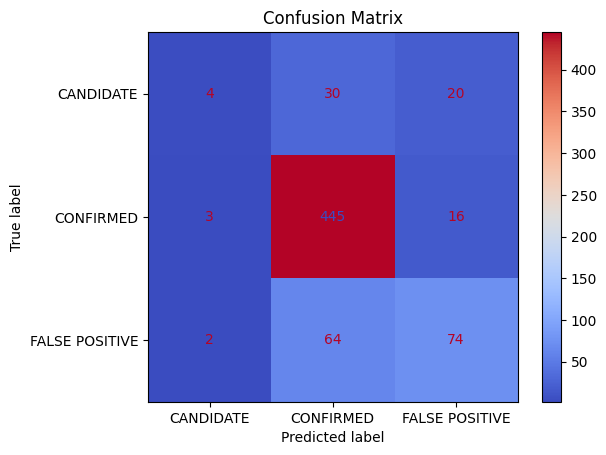

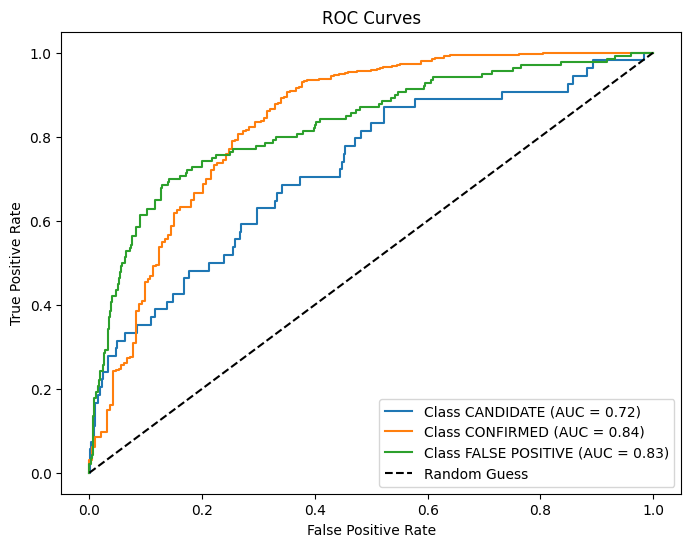

In [48]:
K.clear_session()

model = Sequential([
    Dense(512, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(X_train_filtered.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.2),

    Dense(32, activation='relu', kernel_regularizer=l2(0.0001)),

    Dense(3, activation='softmax')
])

optimizer = Adam(learning_rate = 0.001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_filtered, y_train,
    epochs=150,
    batch_size=64,
    validation_split = 0.2,
    callbacks=[early_stopping]
)

#Accuracy and Loss Plots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()

plt.show()

loss, accuracy = model.evaluate(X_test_filtered, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

#Confusion Matrix
y_pred = model.predict(X_test_filtered)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
labels = ["CANDIDATE", "CONFIRMED", "FALSE POSITIVE"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="coolwarm", values_format="d")
plt.title("Confusion Matrix")
plt.show()

#ROC Curves
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.show()


***

## Model 3: Model 1 FNN Using LeakyReLU instead of ReLU.  

Feature set from Model 1. No other changes.  

Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.6075 - loss: 0.9009 - val_accuracy: 0.7644 - val_loss: 0.7409
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7237 - loss: 0.7311 - val_accuracy: 0.7538 - val_loss: 0.6465
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7525 - loss: 0.6595 - val_accuracy: 0.7781 - val_loss: 0.6230
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7516 - loss: 0.6884 - val_accuracy: 0.7872 - val_loss: 0.5979
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7800 - loss: 0.6299 - val_accuracy: 0.7857 - val_loss: 0.5887
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7753 - loss: 0.6105 - val_accuracy: 0.7903 - val_loss: 0.5921
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7777 - loss: 0.6195 - val_accuracy: 0.7933 - val_loss: 0.5874
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7810 - loss: 0.6167 - val_accuracy: 0.7918 - 

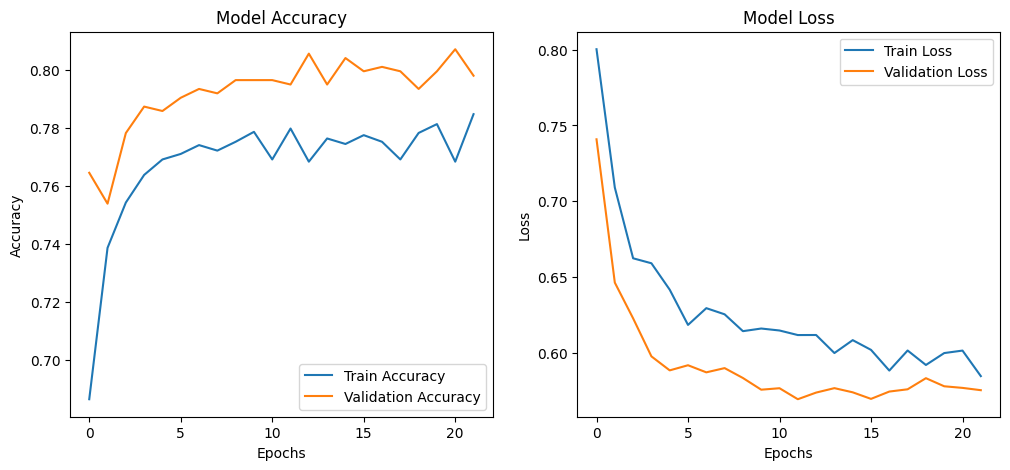

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7999 - loss: 0.5569 
Test Accuracy: 0.7948
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


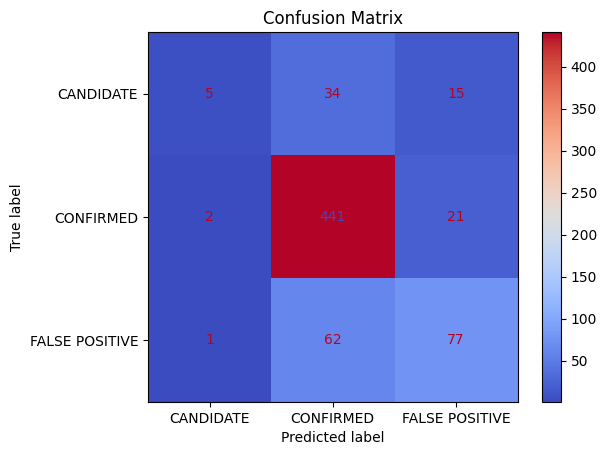

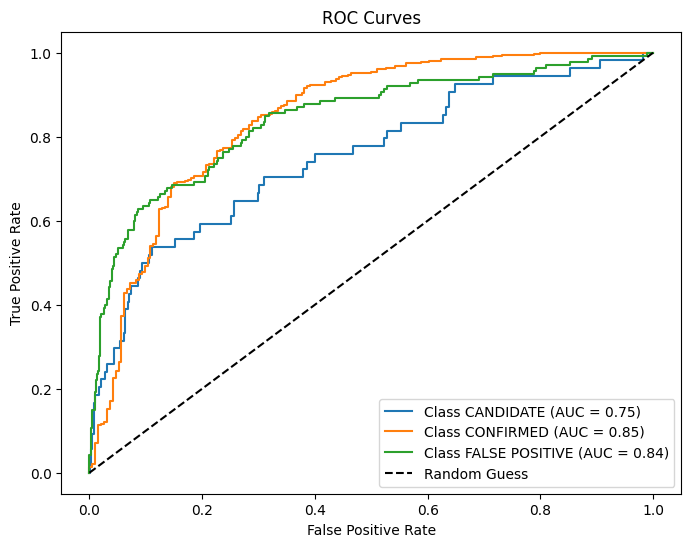

In [49]:
K.clear_session()

model = Sequential([
    Dense(256, input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.3),

    Dense(128),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.3),

    Dense(64),
    LeakyReLU(alpha=0.01),
    Dropout(0.3),

    Dense(3, activation='softmax')
])


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    validation_split = 0.2,
    callbacks=[early_stopping]
)

#Accuracy and Loss Plots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()

plt.show()


loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

#Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
labels = ["CANDIDATE", "CONFIRMED", "FALSE POSITIVE"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="coolwarm", values_format="d")
plt.title("Confusion Matrix")
plt.show()

#ROC Curves
y_test_bin = label_binarize(y_true, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.show()

So each of these models performs similarly in terms of accuracy when rerun multiple times (~0.79-0.82%).  Therefore its difficult to declare a clear winner.  

## Writeup Requirements

- Required:
  - Overview of assignment
  - Description of data
  - Summary of methods
  - Summary of model
  - Analysis of results

- Additional:
  - Make a YouTube video walking through your project and notebook OR
  - Publish notebook (make Kaggle notebook public, publish to Github, publish to blog, etc.)


***

## Writeup

Preliminary version.  Will include writeup with final version.  

Reed Johnson 3/7/2024